In [23]:
#Import Libraries
import tensorflow as tf
import numpy as np
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time
import scipy.io as sio

import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

from utils.utils import save_model

%matplotlib notebook

In [24]:
def generate_batches(X, Y, n_hidden=150):
    len_data = X.shape[0]
    len_batch = len_data-n_hidden
    
    output_X = np.zeros((len_batch, n_hidden))
    output_Y = np.zeros((len_batch, n_hidden, 2))
    
    for i in range(len_batch):
        output_X[i] = X[i:i+n_hidden]
        output_Y[i] = Y[i:i+n_hidden]
    return output_X, output_Y

In [25]:
data = sio.loadmat('data/lfpTrace_ripples.mat')

X = data['lfp'].flatten()
ripple_loc = (data['rippleLocs'].T).flatten()
Y_start = np.zeros_like(X)

In [26]:
window = 25

for i in ripple_loc:
    Y_start[i-window:i+window] = 1
    
res = tf.one_hot(Y_start, depth=2)
with tf.Session() as sess:
    Y = (sess.run(res))

In [27]:
np.sum(Y_start) / len(Y_start)

0.012236825349661482

In [28]:
n_hidden=100

X_batch, Y_batch = generate_batches(X, Y, n_hidden=n_hidden)

<IPython.core.display.Javascript object>


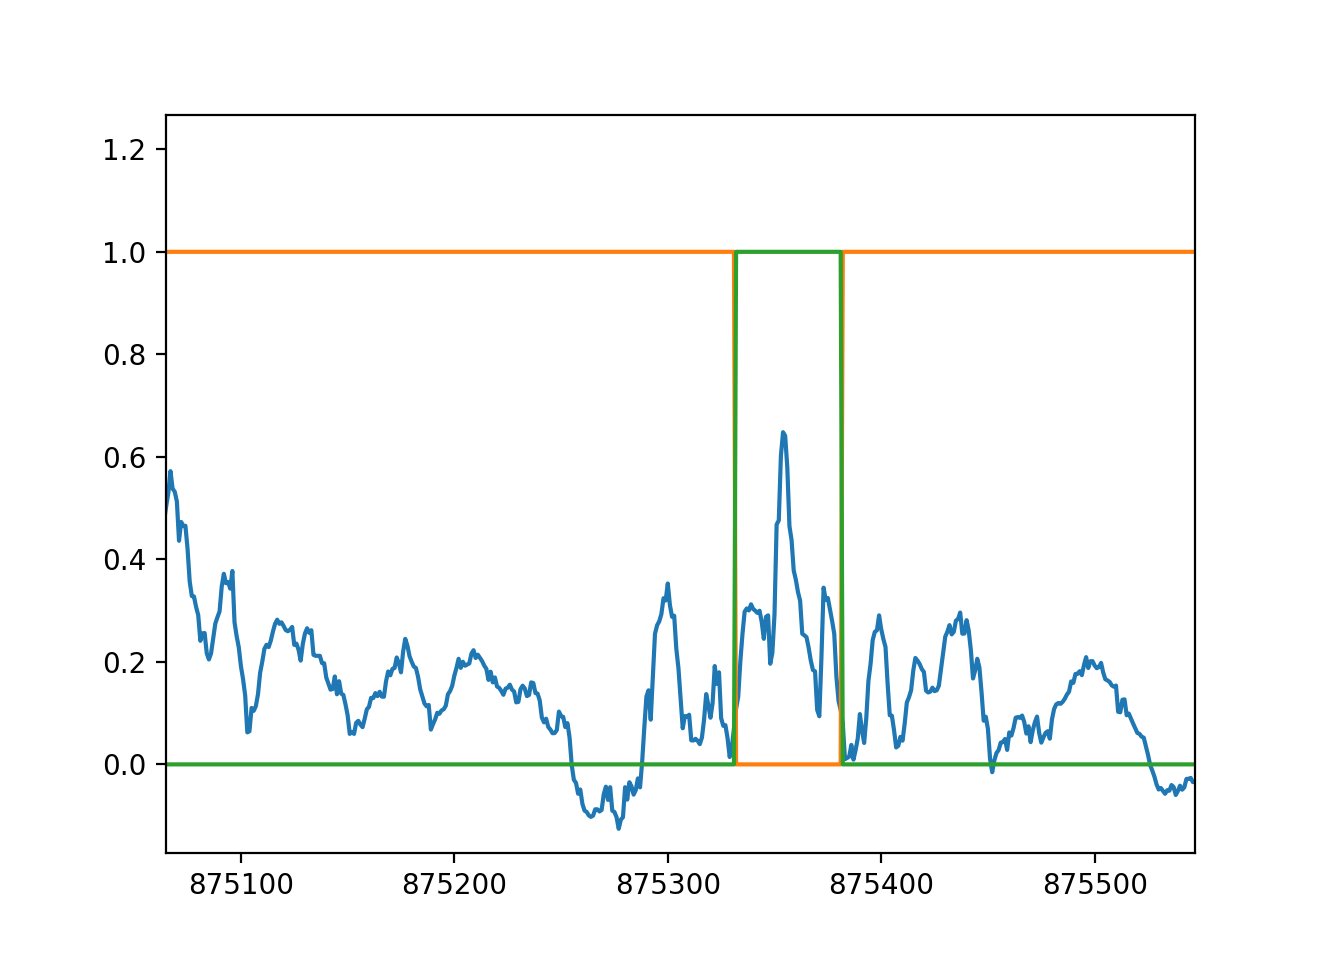

In [31]:
plt.figure()
plt.plot(X)
plt.plot(Y)
# plt.xlim(12500, 14000)
plt.show()

In [7]:
X_batch.shape

(1507644, 100)

In [8]:
X_batch = np.reshape(X_batch, (X_batch.shape[0], X_batch.shape[1], 1))

n_split = 1200000
n_split = 120000

train_input = X_batch[:n_split]
train_output = Y_batch[:n_split]
test_input = X_batch[n_split:]
test_output = Y_batch[n_split:]

test_input = X_batch[n_split:n_split+10000]
test_output = Y_batch[n_split:n_split+10000]

In [9]:
X_batch.shape

(1507644, 100, 1)

In [32]:
n_dim = 1
input_shape = (None,n_dim)
batch_size = 200

keras.backend.clear_session()
inputs = keras.layers.Input(shape=input_shape)

x = keras.layers.LSTM(100, activation='tanh', return_sequences=True)(inputs)
x = keras.layers.LSTM(100, activation='tanh', return_sequences=True)(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)

model = keras.models.Model(inputs=inputs, outputs=predictions)
model.compile(loss=['categorical_crossentropy'],
              optimizer=keras.optimizers.Adam(lr=0.01))


print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 100)         40800     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 100)         80400     
_________________________________________________________________
dense_1 (Dense)              (None, None, 2)           202       
Total params: 121,402
Trainable params: 121,402
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
epochs = 2

history = model.fit(train_input, train_output, batch_size=batch_size, epochs=epochs, 
                    verbose=True, validation_data=(test_input, test_output))

save_model(model)

Train on 120000 samples, validate on 10000 samples
Epoch 1/2
120000/120000 [==============================] - 264s 2ms/step - loss: 0.0732 - val_loss: 0.1514
Epoch 2/2
120000/120000 [==============================] - 261s 2ms/step - loss: 0.0559 - val_loss: 0.0997


In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
res = model.predict(test_input)

In [ ]:
save_dir = 'plots'

if not os.path.exists(save_dir):
        os.makedirs(save_dir)

for i in range(res.shape[0]):
# for i in range(50):
    path = os.path.join(save_dir, str(i)+'.pdf')  
    plt.figure()
    plt.plot(test_input[i], lw=2)
    plt.plot(np.argmax(res[i], axis=1)-2, lw=2)
    plt.plot(np.argmax(test_output[i], axis=1)-2, lw=2)
    plt.ylim(-2., 2.)
    plt.savefig(path)
    plt.close()

In [ ]:
res.shape